
[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python -m pip install --upgrade pip
Data size: 100 | Trn Loss: 2.2978 | Val Loss: 2.2999
Data size: 101 | Trn Loss: 2.2986 | Val Loss: 2.2899
Data size: 102 | Trn Loss: 2.2826 | Val Loss: 2.2798
Data size: 103 | Trn Loss: 2.2754 | Val Loss: 2.2696
Data size: 104 | Trn Loss: 2.2753 | Val Loss: 2.2596
Data size: 105 | Trn Loss: 2.2559 | Val Loss: 2.2497
Data size: 106 | Trn Loss: 2.2404 | Val Loss: 2.2397
Data size: 107 | Trn Loss: 2.2507 | Val Loss: 2.2296
Data size: 108 | Trn Loss: 2.2238 | Val Loss: 2.2196
Data size: 109 | Trn Loss: 2.2242 | Val Loss: 2.2095
Data size: 110 | Trn Loss: 2.2085 | Val Loss: 2.1993
Data size: 111 | Trn Loss: 2.2091 | Val Loss: 2.1890
Data size: 112 | Trn Loss: 2.2025 | Val Loss: 2.1788
Data size: 113 | Trn Loss: 2.1692 | Val Loss: 2.1683
Data size: 114 | Trn Loss: 2.1706 | Val Loss: 2.1578
Data size: 115 | Trn Loss: 2.1642 | Val Loss: 2.1472
Data size: 116 | Trn Loss: 2.14

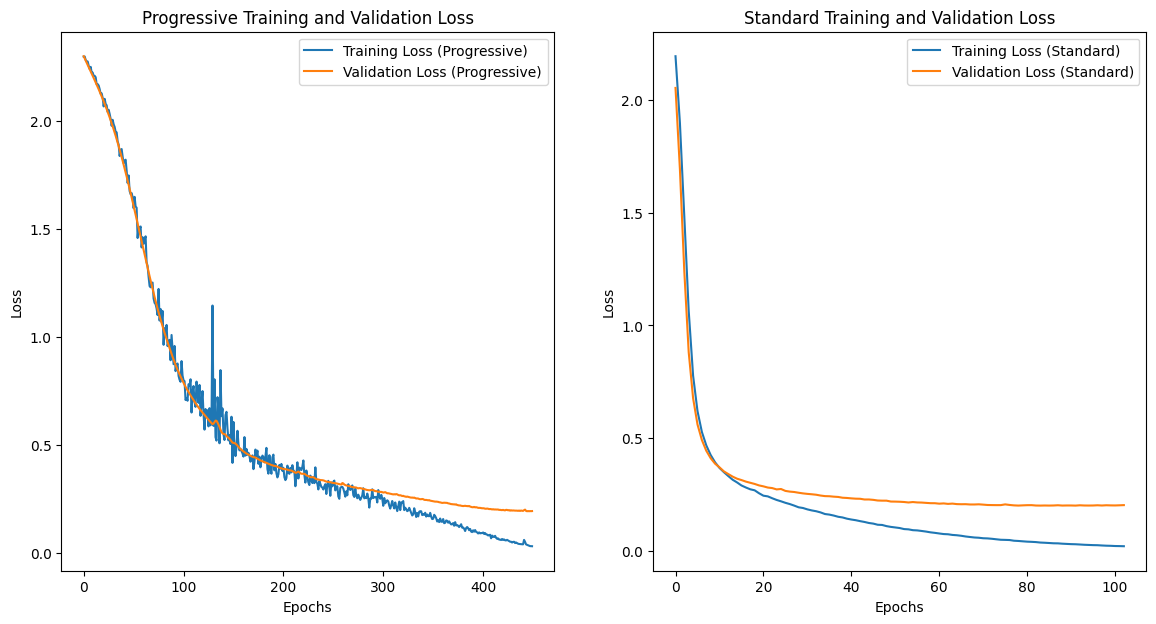

In [8]:
# Install necessary packages
!pip install -q torch torchvision matplotlib

# Import Libraries
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import time

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load and Prepare Data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST('.', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('.', train=False, transform=transform)

BATCH_SIZE = 256
LEARNING_RATE = 5e-5
INITIAL_SIZE = 100  # Initial dataset size
INCREMENT_RATIO = 0.01  # Increment ratio for each step
EPOCHS = 103
OVERALL_DATA_SIZE = 5000  # Overall data size to use from the dataset

# Select subset of data
train_subset, _ = torch.utils.data.random_split(train_dataset, [OVERALL_DATA_SIZE, len(train_dataset) - OVERALL_DATA_SIZE])
train_loader = torch.utils.data.DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Define the Model
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28 * 28, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = SimpleNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Progressive Training Function
def progressive_training(model, train_loader, test_loader, initial_size, increment_ratio):
    total_size = len(train_loader.dataset)
    current_size = initial_size
    train_losses = []
    val_losses = []
    total_samples_trained = 0

    start_time = time.time()

    while current_size <= total_size:
        model.train()
        running_loss = 0.0
        indices = torch.randperm(total_size)[:current_size]
        subset = torch.utils.data.Subset(train_loader.dataset, indices)
        #subset = torch.utils.data.Subset(train_loader.dataset, range(current_size))
        subset_loader = torch.utils.data.DataLoader(subset, batch_size=BATCH_SIZE, shuffle=True)

        for inputs, labels in subset_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_losses.append(running_loss / len(subset_loader))

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        val_losses.append(val_loss / len(test_loader))

        total_samples_trained += current_size

        print(f"Data size: {current_size} | Trn Loss: {running_loss / len(subset_loader):.4f} | Val Loss: {val_loss / len(test_loader):.4f}")

        current_size += int(current_size * increment_ratio)

    end_time = time.time()
    total_runtime = end_time - start_time
    print(f"Total training time (progressive): {total_runtime:.2f} seconds")
    print(f"Total data trained on (progressive): {total_samples_trained}")

    return train_losses, val_losses

# Standard Training Function
def standard_training(model, train_loader, test_loader, epochs):
    train_losses = []
    val_losses = []
    total_samples_trained = 0

    start_time = time.time()

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_losses.append(running_loss / len(train_loader))

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        val_losses.append(val_loss / len(test_loader))

        total_samples_trained += len(train_loader.dataset)

        print(f"Epoch {epoch+1}/{epochs} | Trn Loss: {running_loss / len(train_loader):.4f} | Val Loss: {val_loss / len(test_loader):.4f}")

    end_time = time.time()
    total_runtime = end_time - start_time
    print(f"Total training time (standard): {total_runtime:.2f} seconds")
    print(f"Total data trained on (standard): {total_samples_trained}")

    return train_losses, val_losses

# Progressive Training
model = SimpleNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
train_losses_prog, val_losses_prog = progressive_training(model, train_loader, test_loader, INITIAL_SIZE, INCREMENT_RATIO)

# Standard Training
model = SimpleNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
train_losses_std, val_losses_std = standard_training(model, train_loader, test_loader, EPOCHS)

# Plot Training and Validation Loss
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
plt.plot(train_losses_prog, label='Training Loss (Progressive)')
plt.plot(val_losses_prog, label='Validation Loss (Progressive)')
plt.title('Progressive Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_losses_std, label='Training Loss (Standard)')
plt.plot(val_losses_std, label='Validation Loss (Standard)')
plt.title('Standard Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()



[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python -m pip install --upgrade pip
Data size: 100 | Trn Loss: 2.3154 | Val Loss: 2.3107 | Pplx: 10.1290
Data size: 101 | Trn Loss: 2.2951 | Val Loss: 2.3003 | Pplx: 9.9253
Data size: 102 | Trn Loss: 2.2747 | Val Loss: 2.2899 | Pplx: 9.7254
Data size: 103 | Trn Loss: 2.2552 | Val Loss: 2.2795 | Pplx: 9.5374
Data size: 104 | Trn Loss: 2.2360 | Val Loss: 2.2692 | Pplx: 9.3562
Data size: 105 | Trn Loss: 2.2177 | Val Loss: 2.2588 | Pplx: 9.1861
Data size: 106 | Trn Loss: 2.1975 | Val Loss: 2.2484 | Pplx: 9.0027
Data size: 107 | Trn Loss: 2.1777 | Val Loss: 2.2379 | Pplx: 8.8261
Data size: 108 | Trn Loss: 2.1590 | Val Loss: 2.2275 | Pplx: 8.6626
Data size: 109 | Trn Loss: 2.1406 | Val Loss: 2.2169 | Pplx: 8.5045
Data size: 110 | Trn Loss: 2.1234 | Val Loss: 2.2062 | Pplx: 8.3595
Data size: 111 | Trn Loss: 2.1048 | Val Loss: 2.1953 | Pplx: 8.2055
Data size: 112 | Trn Loss: 2.0867 | Val Loss: 2.1843 | Pplx: 8

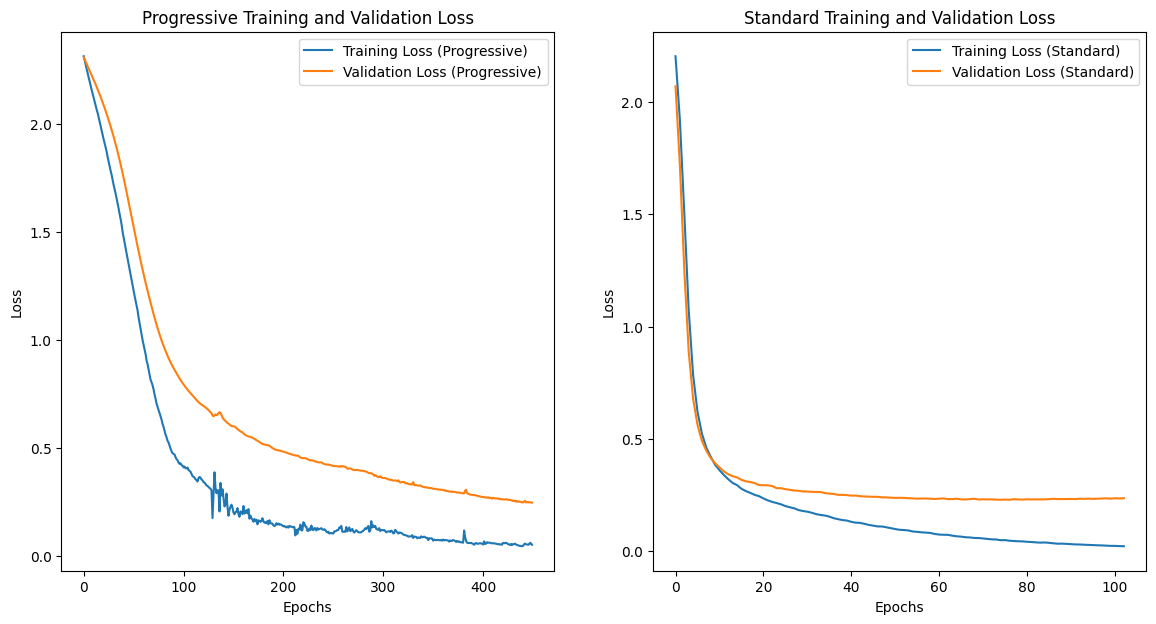

In [6]:
# Install necessary packages
!pip install -q torch torchvision matplotlib

# Import Libraries
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import time

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load and Prepare Data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST('.', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('.', train=False, transform=transform)

BATCH_SIZE = 256
LEARNING_RATE = 5e-5
INITIAL_SIZE = 100  # Initial dataset size
INCREMENT_RATIO = 0.01  # Increment ratio for each step
EPOCHS = 103
OVERALL_DATA_SIZE = 5000  # Overall data size to use from the dataset

# Select subset of data
train_subset, _ = torch.utils.data.random_split(train_dataset, [OVERALL_DATA_SIZE, len(train_dataset) - OVERALL_DATA_SIZE])
train_loader = torch.utils.data.DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Define the Model
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28 * 28, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = SimpleNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Progressive Training Function
def progressive_training(model, train_loader, test_loader, initial_size, increment_ratio):
    total_size = len(train_loader.dataset)
    current_size = initial_size
    train_losses = []
    val_losses = []

    start_time = time.time()

    while current_size <= total_size:
        model.train()
        running_loss = 0.0

        #indices = torch.randperm(total_size)[:current_size]
        #subset = torch.utils.data.Subset(train_loader.dataset, indices)
        
        subset = torch.utils.data.Subset(train_loader.dataset, range(current_size))
        subset_loader = torch.utils.data.DataLoader(subset, batch_size=BATCH_SIZE, shuffle=True)

        for inputs, labels in subset_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_losses.append(running_loss / len(subset_loader))

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        val_losses.append(val_loss / len(test_loader))

        print(f"Data size: {current_size} | Trn Loss: {running_loss / len(subset_loader):.4f} | Val Loss: {val_loss / len(test_loader):.4f}")

        current_size += int(current_size * increment_ratio)

    end_time = time.time()
    total_runtime = end_time - start_time
    print(f"Total training time: {total_runtime:.2f} seconds")

    return train_losses, val_losses

# Standard Training Function
def standard_training(model, train_loader, test_loader, epochs):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_losses.append(running_loss / len(train_loader))

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        val_losses.append(val_loss / len(test_loader))

    return train_losses, val_losses

# Progressive Training
model = SimpleNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
train_losses_prog, val_losses_prog = progressive_training(model, train_loader, test_loader, INITIAL_SIZE, INCREMENT_RATIO)

# Standard Training
model = SimpleNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
train_losses_std, val_losses_std = standard_training(model, train_loader, test_loader, EPOCHS)

# Plot Training and Validation Loss
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
plt.plot(train_losses_prog, label='Training Loss (Progressive)')
plt.plot(val_losses_prog, label='Validation Loss (Progressive)')
plt.title('Progressive Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_losses_std, label='Training Loss (Standard)')
plt.plot(val_losses_std, label='Validation Loss (Standard)')
plt.title('Standard Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [3]:
# Configuration
INITIAL_SIZE = 100  # Initial dataset size
INCREMENT_RATIO = 0.01  # Increment ratio for each step
OVERALL_DATA_SIZE = 5000  # Overall data size to use from the dataset

# Function to simulate progressive training and count total samples used
def simulate_progressive_training(initial_size, increment_ratio, max_size):
    total_samples = 0
    current_size = initial_size

    while current_size <= max_size:
        # Count the samples
        total_samples += current_size
        current_size += int(current_size * increment_ratio)

    return total_samples

# Calculate total samples for progressive training
total_progressive_samples = simulate_progressive_training(INITIAL_SIZE, INCREMENT_RATIO, OVERALL_DATA_SIZE)
print(f"Total samples used in progressive training: {total_progressive_samples}")

# Calculate the number of epochs for standard training
standard_epochs = total_progressive_samples // OVERALL_DATA_SIZE
print(f"Calculated epochs for standard training: {standard_epochs}")


Total samples used in progressive training: 516272
Calculated epochs for standard training: 103
